# 1) Setup

### 1.1 Install Dependencies 

In [1]:
!pip install tensorflow==2.4.1 tensorflow.gpu==2.4.1 opencv.python matplotlib

### 1.2 Import dependencies

In [2]:
#import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#import tensorflow dependencies- functional APIs
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D ,MaxPooling2D, Input, Flatten,Dense,Embedding
import tensorflow as tf


### 1.3 Set GPU Growth

In [4]:
#Avoid out of memoery errs by gpu settings
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### 1.4 Create Folder Structures

In [5]:
 # Setup paths
POS_PATH= os.path.join('data', 'positive')
NEG_PATH= os.path.join('data', 'negative')
ANC_PATH= os.path.join('data', 'anchor')

In [6]:
POS_PATH

'data\\positive'

In [7]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

## 2) Collect Positive And Anchors

### 2.1 Untar Labelled Faces in the Wild Dataset

In [8]:
#Uncompress Tar Gz LAbelled Faces in the wild Dataset 
!tar -xf lfw.tgz

In [9]:
#Move LFW  Images to the following repositries data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

### 2.2 Collect the Positive and Anchor Classes 

In [10]:
#import uuid (universal unique identifier)
import uuid

In [11]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\f8e333f0-1b16-11ee-9b1e-ec2e98e4243e.jpg'

In [12]:
#Establish a connection to webcam
cap =cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame =cap.read()
    
    #Cut down Frame to 250 x 250px
    frame=frame[120:120+250 ,150:250+250,:]
    
    #collect anchors
    if cv2.waitKey(1)  & 0XFF == ord('a'):
        #create the unique file path
        imgname= os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write the anchor image
        cv2.imwrite(imgname,frame)
        
        
    #collect positives
    if cv2.waitKey(1)  & 0XFF == ord('p'):
        #create the unique file path
        imgname= os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write the anchor image
        cv2.imwrite(imgname,frame)
    
    #Show the image back to screen
    cv2.imshow('Image Collection', frame)
    
    #Breaking away
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
#Release the webcam
cap.release()
#close the image show frame
cv2.destroyAllWindows()

## 3) Load and Preprocess Images

### 3.1 Get Image Directories 

In [13]:
anchor =  tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(50) #taking 300 imgs paths
positive= tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(50)
negative= tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(50)


In [14]:
dir_test =anchor.as_numpy_iterator()

In [15]:
print(dir_test.next())

b'data\\anchor\\237ad260-1810-11ee-9b64-bb6c8d9fd767.jpg'


### 3.2 Preprocessing - Scale and Resize

In [16]:
def preprocess(file_path):
    
    #Read the image from the file path
    byte_img =tf.io.read_file(file_path)
    #Load the image
    img = tf.io.decode_jpeg(byte_img)
    
    #Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    
    #Scaling the image between 0 and 1 to help in gradient decent and optomize our model
    img = img/ 255.0
    return img
    

In [17]:
img = preprocess('data\\anchor\\20105445-1810-11ee-ac5d-bb6c8d9fd767.jpg')

In [18]:
img.numpy().max()

1.0

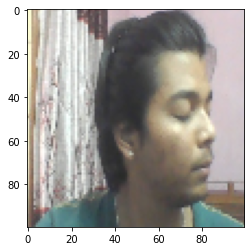

In [19]:
plt.imshow(img)

### 3.3 Create Labelled Dataset

In [20]:
# (anchor, positive) => 1,1,1,1
# (anchor, negative) => 1,1,1,1

In [21]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [22]:
iterator_lab = class_labels.as_numpy_iterator()

In [23]:
iterator_lab.next()

0.0

In [24]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))) #label as one
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))) #label as zero
#joining the positives and negatives
data = positives.concatenate(negatives)

In [25]:
samples = data.as_numpy_iterator()

In [26]:
example =samples.next()

In [27]:
example

(b'data\\anchor\\e1187b1c-180f-11ee-a882-bb6c8d9fd767.jpg',
 b'data\\positive\\072e166d-1810-11ee-86bb-bb6c8d9fd767.jpg',
 1.0)

### 3.4 Build Train and Test Partition

In [28]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [29]:
result =preprocess_twin(*example)


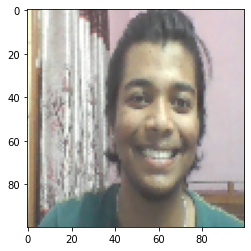

In [30]:
plt.imshow(result[1])

In [31]:
result[2]

1.0

In [32]:
# BUILD THE DATA PIPELINE

data =data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [33]:
samples =data.as_numpy_iterator()

In [34]:
len(samples.next()) #anchor in 1st, pos./neg. in 2nd

3

In [53]:
samp=samples.next()

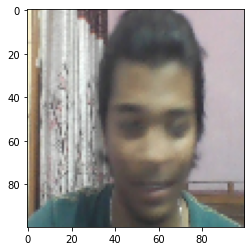

In [54]:
 plt.imshow(samp[0])

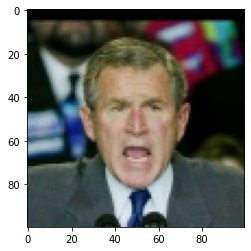

In [55]:
 plt.imshow(samp[1])

In [56]:
samp[2] #the label should be 0 since both don't matches

0.0

In [57]:
samp=samples.next()

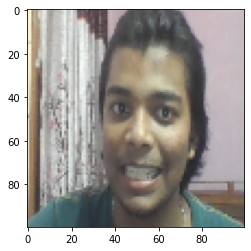

In [58]:
 plt.imshow(samp[0])

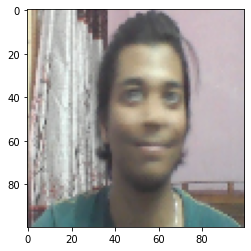

In [59]:
 plt.imshow(samp[1])

In [60]:
samp[2] #label should show 1 as it's a match

1.0

In [61]:
 round(len(data)*.7) #taking data for first 70%

70

In [62]:
data

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [63]:
##TRAINING PARTITION
train_data = data.take(round(len(data)*.7)) #%70% data for training
train_data = train_data.batch(16) #taking 16 photos ata time
train_data = train_data.prefetch(8) #fetching the 8 photos while 16 is processed

In [64]:
train_samples =train_data.as_numpy_iterator()

In [65]:
train_samples =train_samples.next()

In [66]:
len(train_samples[0])

16

In [67]:
round(len(data)*.3) #30% remaining for test set

30

In [68]:
##TESTING PARTITION
test_data = data.skip(round(len(data)*.7)) #skip th 1st 70%
test_data = test_data.take(round(len(data)*.3)) #30% remaining data
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4) Model Engineering 

### 4.1 Build the Embedded Layer

In [69]:
#input example of creating layer
inp = Input(shape=(105,105,3), name= 'input_image')
#convolutional Layer-1
c1 = Conv2D(64,(10,10), activation= 'relu')(inp)
#max pooling
m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)

In [70]:
c1

<KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d')>

In [71]:
m1

<KerasTensor: shape=(None, 48, 48, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [72]:
def make_embedding():
    inp = Input(shape= (100,100,3), name='input_image')
    
    #first block of layer---64 filters 10x10 pixels
    c1 = Conv2D(64,(10,10), activation= 'relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)
    
    #second block of layer---128 filters 7x7 pixels
    c2 = Conv2D(128,(7,7), activation= 'relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding = 'same')(c2)
    
    #third block of layer---128 filters 4x4 pixels
    c3 = Conv2D(128,(4,4), activation= 'relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding = 'same')(c3)
    
    #Final Embedded Block
    c4 = Conv2D(256, (4,4), activation= 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation= 'sigmoid')(f1)
    
    return Model(inputs= [inp] , outputs=[d1] , name='embedding' ) #pass all the blocks in model to compile it

In [73]:
embedding=make_embedding()

In [74]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 128)         0 

### 4.2 Build The Distance Layer 

In [75]:
#Siamese L1 distance class
class L1Dist(Layer):
    
    ##init method - inheritance
    def __init__(self,**kwargs):
        super().__init__()
        
    ##Passing two streams of images 1-anchor 2-positve/negative for similarity comparison
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding) #by subtraction

In [76]:
l1= L1Dist()

In [77]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

### 4.3 Make Siamese Model

In [78]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [79]:
siamese_model = make_siamese_model()

In [80]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

# 5)  Training

### 5.1 Setup Loss and Optimizer 

In [81]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [82]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

### 5.2 Establish Checkpoints

In [83]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### 5.3 Build Train Step Function

In [84]:
test_batch = train_data.as_numpy_iterator()

In [85]:
batch_1 = test_batch.next()

In [86]:
X = batch_1[:2]

In [87]:
np.array(X)

array([[[[[0.97107846, 0.94191176, 0.79019606],
          [0.98284316, 0.97083336, 0.8335784 ],
          [0.6580882 , 0.6071078 , 0.5061275 ],
          ...,
          [0.7970588 , 0.73039216, 0.7617647 ],
          [0.79509807, 0.7362745 , 0.7637255 ],
          [0.78431374, 0.73333335, 0.76862746]],

         [[0.98357844, 0.9558824 , 0.8012255 ],
          [0.96813726, 0.95392156, 0.81397057],
          [0.6485294 , 0.5892157 , 0.485049  ],
          ...,
          [0.8009804 , 0.74215686, 0.7617647 ],
          [0.7970588 , 0.7411765 , 0.75980395],
          [0.78431374, 0.735049  , 0.7654412 ]],

         [[0.96960783, 0.9519608 , 0.7882353 ],
          [0.9632353 , 0.94166666, 0.7995098 ],
          [0.66862744, 0.5997549 , 0.4987745 ],
          ...,
          [0.7970588 , 0.7382353 , 0.7519608 ],
          [0.7889706 , 0.74191177, 0.75171566],
          [0.78137255, 0.7372549 , 0.75441176]],

         ...,

         [[0.5235294 , 0.48382354, 0.40269607],
          [0.54264706,

In [88]:
y = batch_1[2]

In [89]:
y

array([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.],
      dtype=float32)

In [90]:
@tf.function
def train_step(batch):
    
    #Record all our operations 
    with tf.GradientTape() as tape:
        #Get anchor and positive/negative image
        X = batch[:2]
        #Get Label
        y = batch[2]
    
        #pass to Siamese function
        ypred = siamese_model(X, training = True)
        # Calculate Loss
        loss= binary_cross_loss(y,ypred)

    print(loss)
    #Calculate Gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    #Calculate Updated weights and apply the siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    #return loss
    return loss

### 5.4 Build Training Loop 

In [91]:
def train(data, EPOCHS):
    
    #Loop through epochs
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        #Loop through each batch
        for idx, batch in enumerate (data):
            # Run train steps Here 
            train_step(batch)
            progbar.update(idx+1)
            
        #Save checkpoints
        if epoch %10 ==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

### 5.5 Train The Model

In [95]:
EPOCHS=10

In [96]:
train(train_data,EPOCHS)


 Epoch 1/10
5/5 [==============================] - 67s 13s/step

 Epoch 2/10
5/5 [==============================] - 67s 13s/step

 Epoch 3/10
5/5 [==============================] - 66s 13s/step

 Epoch 4/10
5/5 [==============================] - 65s 13s/step

 Epoch 5/10
5/5 [==============================] - 65s 13s/step

 Epoch 6/10
5/5 [==============================] - 65s 12s/step

 Epoch 7/10
5/5 [==============================] - 65s 13s/step

 Epoch 8/10
5/5 [==============================] - 65s 13s/step

 Epoch 9/10
5/5 [==============================] - 74s 15s/step

 Epoch 10/10
5/5 [==============================] - 73s 14s/step


# 6) Evaluate Model

### 6.1 Import Metrics

In [97]:
#Input metric calculation 
from tensorflow.keras.metrics import Precision, Recall

### 6.2 Make Predictions

In [98]:
# get a batch of test data
test_input , test_val, y_true = test_data.as_numpy_iterator().next()

In [99]:
#Make prediction 
ypred = siamese_model.predict([test_input, test_val])
ypred

array([[3.7814081e-03],
       [9.9705851e-01],
       [9.4686055e-01],
       [9.5084488e-01],
       [7.3626781e-01],
       [9.9712062e-01],
       [9.9891460e-01],
       [1.9183755e-04],
       [1.9934773e-04],
       [1.4191866e-04],
       [4.7141910e-03],
       [1.7586350e-04],
       [6.1139464e-04],
       [5.9381127e-04],
       [7.6046795e-02],
       [9.8088664e-01]], dtype=float32)

In [100]:
#post preprocessing the results
[1 if prediction > 0.5 else 0 for prediction in ypred]

[0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [101]:
y_true

array([0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

### 6.3 Calculate Metrics 

In [102]:
#Create a metric object
m=Precision() #or use Recall()

#Calculating the recall value
m.update_state(y_true, ypred)

#Return Recall Result
m.result().numpy()

1.0

In [103]:
#Create a metric object
m= Recall() #or use Recall()

#Calculating the recall value
m.update_state(y_true, ypred)

#Return Recall Result
m.result().numpy()

1.0

### 6.4 Viz Results

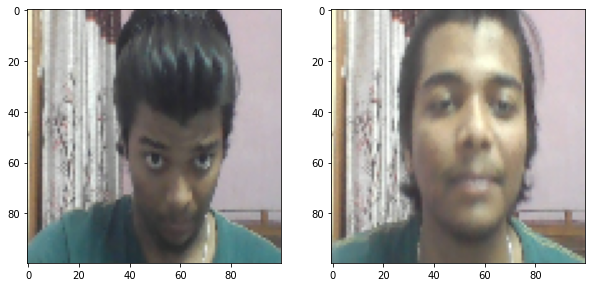

In [104]:
#size of the plot img.
plt.figure(figsize = (10,8))

#set first subplot img.
plt.subplot(1,2,1)
plt.imshow(test_input[3])

#set second subplot img.
plt.subplot(1,2,2)
plt.imshow(test_val[3])

#renders cleanly
plt.show()

# 7) Save Model

In [105]:
# Save Weights 
siamese_model.save('siamesemodel.h5')

In [106]:
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects= {'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [107]:
#make Prediction 
model.predict([test_input, test_val])

array([[3.7814081e-03],
       [9.9705851e-01],
       [9.4686055e-01],
       [9.5084488e-01],
       [7.3626781e-01],
       [9.9712062e-01],
       [9.9891460e-01],
       [1.9183755e-04],
       [1.9934773e-04],
       [1.4191866e-04],
       [4.7141910e-03],
       [1.7586350e-04],
       [6.1139464e-04],
       [5.9381127e-04],
       [7.6046795e-02],
       [9.8088664e-01]], dtype=float32)

In [108]:
#view model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8) Real Time Test 

### 8.1 Verification Function 

In [109]:
os.listdir(os.path.join('application_data', 'verification_images'))

['07b095e3-1810-11ee-b2cc-bb6c8d9fd767.jpg',
 '07fb4e49-1810-11ee-bcbc-bb6c8d9fd767.jpg',
 '08bb591b-1810-11ee-aefc-bb6c8d9fd767.jpg',
 '08cbcb95-1810-11ee-a269-bb6c8d9fd767.jpg',
 '08f76595-1810-11ee-bc9e-bb6c8d9fd767.jpg',
 '09a9b5cb-1810-11ee-90bd-bb6c8d9fd767.jpg',
 '09b127fd-1810-11ee-8bf5-bb6c8d9fd767.jpg',
 '09b8a7ab-1810-11ee-a45b-bb6c8d9fd767.jpg',
 '09f38a28-1810-11ee-819a-bb6c8d9fd767.jpg',
 '0a10a6c0-1810-11ee-9ec2-bb6c8d9fd767.jpg',
 '0a183d64-1810-11ee-9b24-bb6c8d9fd767.jpg',
 '0a261747-1810-11ee-8926-bb6c8d9fd767.jpg',
 '0a484ed1-1810-11ee-9a6e-bb6c8d9fd767.jpg',
 '0a4fa9a5-1810-11ee-8bc2-bb6c8d9fd767.jpg',
 '0a6811c3-1810-11ee-815c-bb6c8d9fd767.jpg',
 '0aa331d4-1810-11ee-a74f-bb6c8d9fd767.jpg',
 '0ac7dd27-1810-11ee-b87c-bb6c8d9fd767.jpg',
 '0ad231c4-1810-11ee-a133-bb6c8d9fd767.jpg',
 '0b078ba8-1810-11ee-a65a-bb6c8d9fd767.jpg',
 '0b0f28b8-1810-11ee-b3f0-bb6c8d9fd767.jpg',
 '0b30111f-1810-11ee-a708-bb6c8d9fd767.jpg',
 '0b59e6de-1810-11ee-9e92-bb6c8d9fd767.jpg',
 '0b99c4cd

In [110]:
os.path.join('application_data', 'input_images','input_images.jpg' )

'application_data\\input_images\\input_images.jpg'

In [111]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\07b095e3-1810-11ee-b2cc-bb6c8d9fd767.jpg
application_data\verification_images\07fb4e49-1810-11ee-bcbc-bb6c8d9fd767.jpg
application_data\verification_images\08bb591b-1810-11ee-aefc-bb6c8d9fd767.jpg
application_data\verification_images\08cbcb95-1810-11ee-a269-bb6c8d9fd767.jpg
application_data\verification_images\08f76595-1810-11ee-bc9e-bb6c8d9fd767.jpg
application_data\verification_images\09a9b5cb-1810-11ee-90bd-bb6c8d9fd767.jpg
application_data\verification_images\09b127fd-1810-11ee-8bf5-bb6c8d9fd767.jpg
application_data\verification_images\09b8a7ab-1810-11ee-a45b-bb6c8d9fd767.jpg
application_data\verification_images\09f38a28-1810-11ee-819a-bb6c8d9fd767.jpg
application_data\verification_images\0a10a6c0-1810-11ee-9ec2-bb6c8d9fd767.jpg
application_data\verification_images\0a183d64-1810-11ee-9b24-bb6c8d9fd767.jpg
application_data\verification_images\0a261747-1810-11ee-8926-bb6c8d9fd767.jpg
application_data\verification_images\0a484ed1-1810-11ee-9a6e-bb6

In [112]:
def verify(model, detection_threshold, verification_threshold):
    #Build results array
    results= []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data','input_images', 'input_images.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        #Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        
    #Detection Threshold : Metric above which a prediction is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    #Verification Threshold : Proportion of positive predictions /total positive samples
    verification = detection/ len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified

### 8.2 OpenCV Real Time Verification

In [113]:
cap =  cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    #Cut down Frame to 250 x 250px
    frame=frame[120:120+250 ,180:250+250,:]
    
    cv2.imshow('Verification',frame)
    
    #Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #save the input image to applic_data/input_img
        cv2.imwrite(os.path.join('application_data','input_images','input_images.jpg'), frame)
        #Run Verification 
        results ,verified = verify(model, 0.6 , 0.5)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

True


In [115]:
np.sum(np.squeeze(results)>0.6)

44